In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from model import RNN_Model, LSTM_Model
from optim import Adam, SGD
from trainer import Trainer, Dataset

In [2]:
data = pd.read_csv('Steel_industry_data.csv')

def feature_norm(df_col):
    return (df_col )/df_col.std()

mapping = {'Monday' : 1, 'Tuesday': 2, 'Wednesday':3, 'Thursday' : 4, 'Friday' : 5, 'Saturday':6, 'Sunday' : 7}
data = data.replace(mapping)
data['date'] = pd.to_datetime(data['date'])
data['Hour'] = feature_norm(data['date'].dt.hour)
data['Month'] = feature_norm(data['date'].dt.month)

data['Day_of_week'] = data['Day_of_week']/data['Day_of_week'].std()
data['NSM'] = feature_norm(data['NSM'])
data['Lagging_Current_Power_Factor'] = feature_norm(data['Lagging_Current_Power_Factor'])
data['Leading_Current_Power_Factor'] = feature_norm(data['Leading_Current_Power_Factor'])
norm_coeff = data['Usage_kWh'].std()
data['Usage_kWh'] = feature_norm(data['Usage_kWh'])

data = data.drop(columns = ['date', 'CO2(tCO2)', 'WeekStatus', 'Leading_Current_Reactive_Power_kVarh', 'date',
                            'Load_Type'])
data = np.array(data)

norm_coeff

33.44437970801463

In [3]:
data

array([[0.09478424, 2.95      , 3.86917991, ..., 0.49914311, 0.        ,
        0.29003157],
       [0.11960156, 4.46      , 3.52882315, ..., 0.49914311, 0.        ,
        0.29003157],
       [0.09687726, 3.28      , 3.71432815, ..., 0.49914311, 0.        ,
        0.29003157],
       ...,
       [0.11302347, 3.17      , 4.04939987, ..., 0.49914311, 3.32260213,
        3.48037883],
       [0.11302347, 3.06      , 4.10753535, ..., 0.49914311, 3.32260213,
        3.48037883],
       [0.10973443, 3.02      , 4.08111013, ..., 0.49914311, 0.        ,
        3.48037883]])

In [4]:
train_size = 0.7
val_size = 0.15 + train_size
test_size = 0.15 + val_size
kern_size = 6
size = len(data)
trainx, trainy = data[:int(train_size * size), 1:], data[kern_size:int(train_size * size), 0].reshape(-1,1)

valx, valy = data[int(train_size * size):int(val_size * size), 1:], data[kern_size + int(train_size * size):int(val_size * size), 0].reshape(-1,1)

testx, testy = data[int(val_size * size):, 1:], data[kern_size + int(val_size * size):, 0].reshape(-1,1)
trainx

array([[ 2.95      ,  3.86917991,  3.28336758, ...,  0.49914311,
         0.        ,  0.29003157],
       [ 4.46      ,  3.52882315,  3.28336758, ...,  0.49914311,
         0.        ,  0.29003157],
       [ 3.28      ,  3.71432815,  3.28336758, ...,  0.49914311,
         0.        ,  0.29003157],
       ...,
       [25.85      ,  4.71425827,  3.28336758, ...,  1.99657243,
         1.58907059,  2.61028413],
       [32.69      ,  4.57367613,  3.28336758, ...,  1.99657243,
         1.58907059,  2.61028413],
       [41.72      ,  4.24071843,  3.28336758, ...,  1.99657243,
         1.73353155,  2.61028413]])

In [5]:
def make_dataset(x, y, kern_size):
    trainx = sliding_window_view(x[:-1], window_shape= (kern_size, x.shape[1]))
    trainx = trainx.squeeze()
    return trainx

trainx = make_dataset(trainx, trainy, 6)
valx = make_dataset(valx, valy, 6)
testx = make_dataset(testx, testy, 6)
dataset = Dataset(trainx, trainy, valx, valy)

print(trainx.shape ,testx.shape)

(24522, 6, 7) (5250, 6, 7)


In [10]:
epoch_num = 7500
lr = 0.01
num_train = len(trainx)
batch_size=len(trainx)


model = RNN_Model(features_num = trainx.shape[2], hidden_rnn_size = 20)
optim = Adam()


trainer = Trainer(model, dataset, optim,num_epochs= epoch_num, batch_size=batch_size, learning_rate=lr)
trainer.fit()

Epoch 0:  Train loss: 1.28675  Val loss: 1.19516
Epoch 50:  Train loss: 0.29675  Val loss: 0.19551
Epoch 100:  Train loss: 0.24113  Val loss: 0.16800
Epoch 150:  Train loss: 0.22439  Val loss: 0.15293
Epoch 200:  Train loss: 0.22551  Val loss: 0.20524
Epoch 250:  Train loss: 0.21034  Val loss: 0.14832
Epoch 300:  Train loss: 0.20440  Val loss: 0.14376
Epoch 350:  Train loss: 0.21029  Val loss: 0.14610
Epoch 400:  Train loss: 0.20109  Val loss: 0.14221
Epoch 450:  Train loss: 0.19526  Val loss: 0.13882
Epoch 500:  Train loss: 0.28252  Val loss: 0.20061
Epoch 550:  Train loss: 0.19885  Val loss: 0.14133
Epoch 600:  Train loss: 0.19387  Val loss: 0.13787
Epoch 650:  Train loss: 0.18970  Val loss: 0.13635
Epoch 700:  Train loss: 0.18589  Val loss: 0.13485
Epoch 750:  Train loss: 0.18231  Val loss: 0.13357
Epoch 800:  Train loss: 0.20940  Val loss: 0.14196
Epoch 850:  Train loss: 0.20122  Val loss: 0.14770
Epoch 900:  Train loss: 0.19908  Val loss: 0.14568
Epoch 950:  Train loss: 0.19711  V

KeyboardInterrupt: 

In [6]:
best_model = RNN_Model(trainx.shape[2], 20)
best_model.load_params('best_rnn_model')


MSE: 119.99097474490809


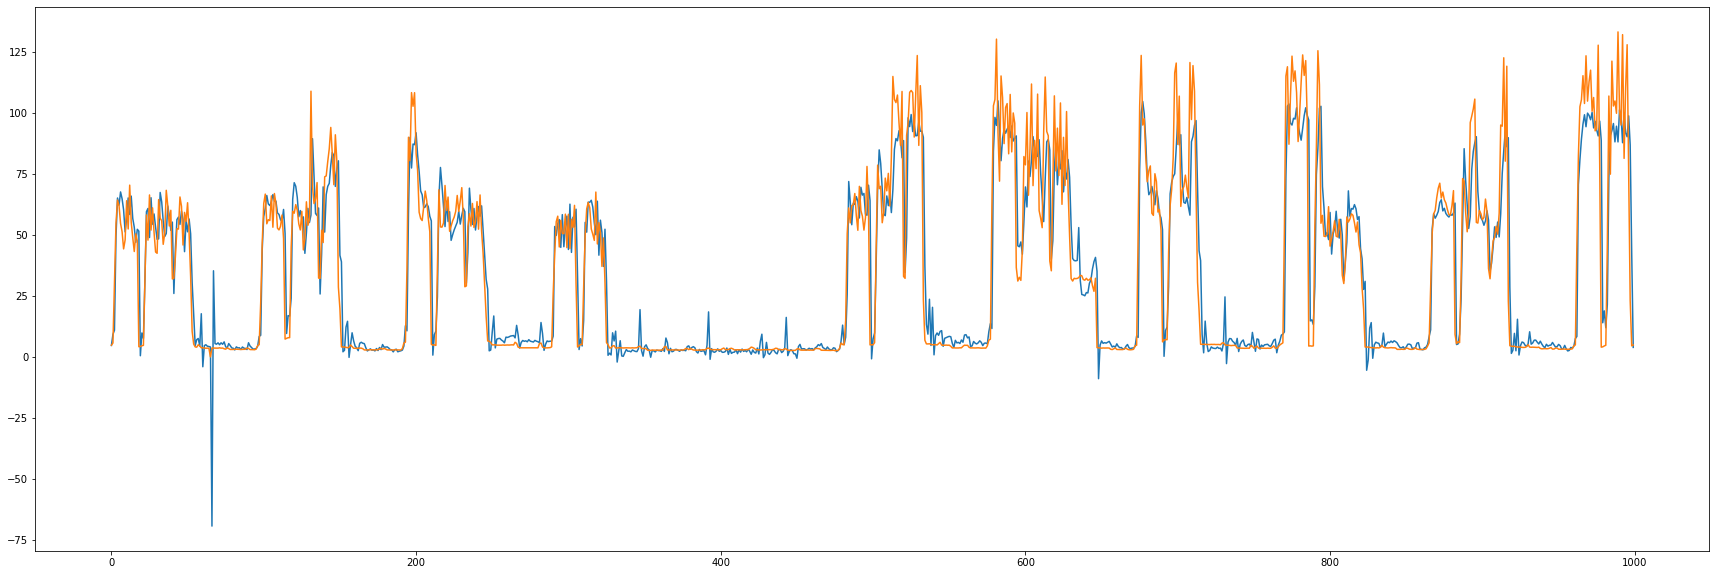

In [7]:
best_model.predict(testx, testy, 1000, norm_coeff)

In [11]:
epoch_num = 1500
lr = 0.001
num_train = len(trainx)
batch_size=len(trainx)


#model = LSTM_Model(features_num = trainx.shape[2], hidden_rnn_size = 20)
optim = Adam()


trainer = Trainer(model, dataset, optim,num_epochs= epoch_num, batch_size=batch_size, learning_rate=lr)
trainer.fit()

Epoch 0:  Train loss: 0.30682  Val loss: 0.24932
Epoch 50:  Train loss: 0.31029  Val loss: 0.25802
Epoch 100:  Train loss: 0.29292  Val loss: 0.24740
Epoch 150:  Train loss: 0.29249  Val loss: 0.25135
Epoch 200:  Train loss: 0.28922  Val loss: 0.23005
Epoch 250:  Train loss: 0.28437  Val loss: 0.23417
Epoch 300:  Train loss: 0.27969  Val loss: 0.23433
Epoch 350:  Train loss: 0.27236  Val loss: 0.22505
Epoch 400:  Train loss: 0.26309  Val loss: 0.22049
Epoch 450:  Train loss: 0.26177  Val loss: 0.22213
Epoch 500:  Train loss: 0.26137  Val loss: 0.22535
Epoch 550:  Train loss: 0.25776  Val loss: 0.23421
Epoch 600:  Train loss: 0.25607  Val loss: 0.22892
Epoch 650:  Train loss: 0.25444  Val loss: 0.22222


KeyboardInterrupt: 

MSE: 214.41391249882926


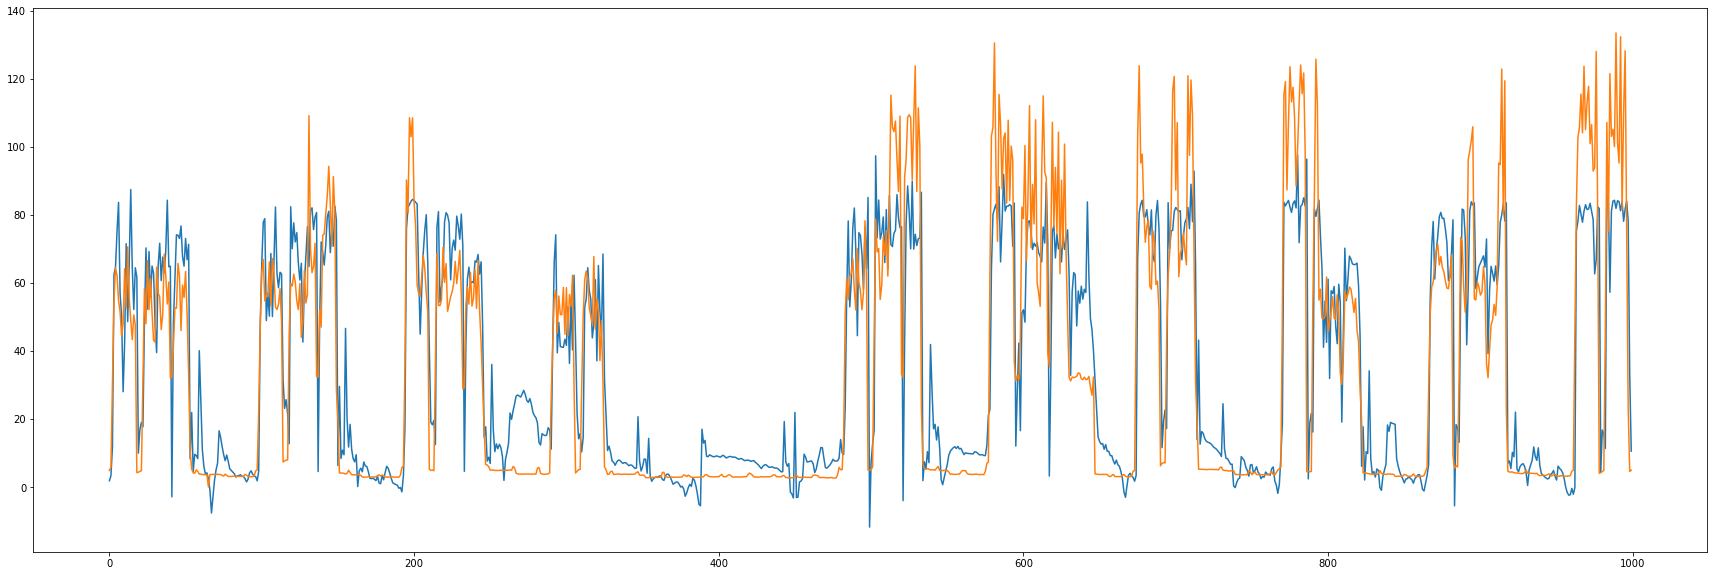

In [8]:
best_model = LSTM_Model(features_num = trainx.shape[2], hidden_rnn_size = 20)
best_model.load_params('best_lstm_model')
best_model.predict(testx, testy, 1000, norm_coeff)